In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('default')
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 
import os
os.environ["PATH"] += os.pathsep + "C:\\Users\\tiagoft1\\Graphviz\\bin"


In [26]:
df = pd.read_csv('./datasets/IMDB Dataset.csv')
vectorizer = CountVectorizer(binary=True, stop_words=stopwords, max_features=1000, max_df=0.4)
X = vectorizer.fit_transform(list(df['review'])).toarray()
print(X.shape)

C:\Users\tiagoft1\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'mon'] not in stop_words.
  warnings.warn(


(50000, 1000)


## One-Hot Encoding

In [27]:
from sklearn.preprocessing import OneHotEncoder
labels = np.array([list(df['sentiment'])]).T
ohe = OneHotEncoder()
y = ohe.fit_transform(labels).toarray()
print(type(y))
print(y.shape)
print(labels[0:5,:])
print(y[0:5,:])


<class 'numpy.ndarray'>
(50000, 2)
[['positive']
 ['positive']
 ['positive']
 ['negative']
 ['positive']]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


# Definindo uma rede neural artificial com Keras

In [28]:
from keras.models import Model
from keras.layers import Input, Dense

In [86]:
def rede_neural_simples(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  y = Dense(n_dims_out, activation='sigmoid', name='classificador')(x)
  return Model(input_layer, y)

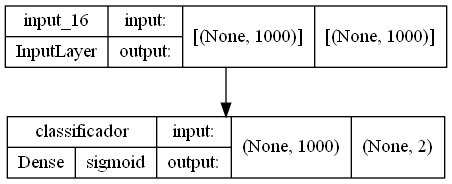

In [87]:
from tensorflow.keras.utils import plot_model

rede_neural = rede_neural_simples(X.shape[1], y.shape[1])
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

## Fit da rede neural

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40000, 1000) (10000, 1000) (40000, 2) (10000, 2)


In [89]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=es)

Epoch 1/500
1000/1000 [==============================] - 2s 1ms/step - loss: 0.1640 - val_loss: 0.1289
Epoch 2/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1203 - val_loss: 0.1142
Epoch 3/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1103 - val_loss: 0.1091
Epoch 4/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1057 - val_loss: 0.1066
Epoch 5/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1031 - val_loss: 0.1052
Epoch 6/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1015 - val_loss: 0.1046
Epoch 7/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1004 - val_loss: 0.1041
Epoch 8/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0996 - val_loss: 0.1041
Epoch 9/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0990 - val_loss: 0.1039
Epoch 10/500
1000/1000 [==============================] - 1s 1ms/step - l

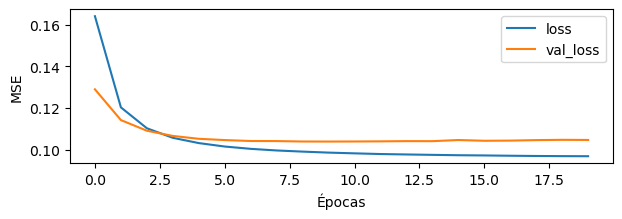

In [90]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Avaliando a rede neural artificial

In [91]:
y_est = rede_neural.predict(X_test)
print(y_est[0:5,:])
print(y_test[0:5,:])

[[0.12344608 0.873389  ]
 [0.5935095  0.40736216]
 [0.70689154 0.2818339 ]
 [0.36279613 0.64255106]
 [0.1315752  0.865324  ]]
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [92]:
from sklearn.metrics import classification_report
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    negative       0.87      0.84      0.85      5057
    positive       0.84      0.87      0.86      4943

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## Quais palavras têm mais peso?

In [93]:
w = rede_neural.get_layer('classificador').get_weights()
#print(w)
#print(w[0])

C:\Users\tiagoft1\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


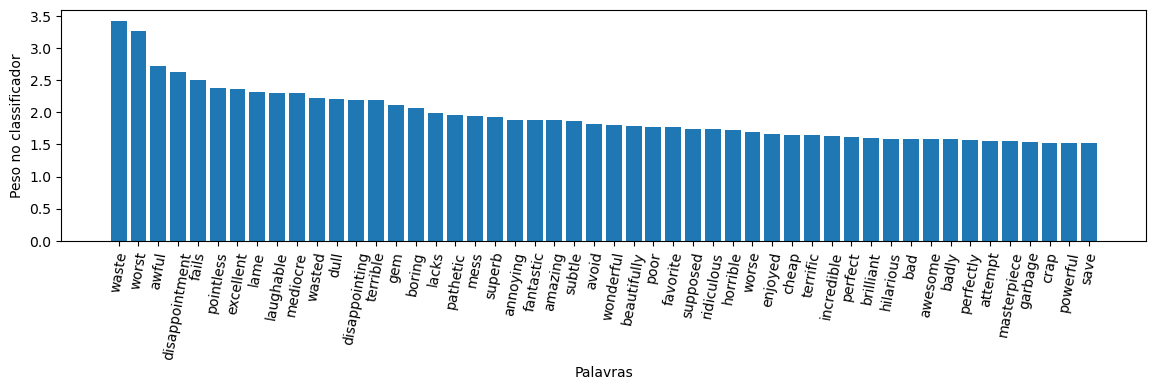

In [94]:
# Visualização 1: quais são as palavras de maior peso?
pesos = np.abs(w[0][:,0] - w[0][:,1])
feature_names = vectorizer.get_feature_names() # Modificar isso para versões mais atuais do sklearn
pares = [ (pesos[i], feature_names[i]) for i in range(len(feature_names))]
pares = sorted(pares, reverse=True)
pesos_ = [c[0] for c in pares]
palavras_ = [c[1] for c in pares]

n_palavras = 50
plt.figure(figsize=(14,3))
plt.bar(np.arange(n_palavras), pesos_[0:n_palavras])
plt.xticks(np.arange(n_palavras), palavras_[0:n_palavras], rotation=80)
plt.xlabel('Palavras')
plt.ylabel('Peso no classificador')
plt.show()

# Projeções intermediárias

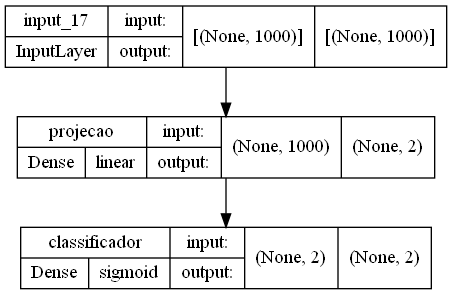

In [96]:
def rede_neural_proj(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Dense(2, name='projecao')(x)
  y = Dense(n_dims_out, activation='sigmoid', name='classificador')(x)
  return Model(input_layer, y)

rede_neural = rede_neural_proj(X.shape[1], y.shape[1])
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [97]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=es)

Epoch 1/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1493 - val_loss: 0.1099
Epoch 2/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1053 - val_loss: 0.1040
Epoch 3/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1012 - val_loss: 0.1038
Epoch 4/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0999 - val_loss: 0.1043
Epoch 5/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0995 - val_loss: 0.1045
Epoch 6/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0992 - val_loss: 0.1048
Epoch 7/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0990 - val_loss: 0.1061
Epoch 8/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0989 - val_loss: 0.1055
Epoch 9/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0987 - val_loss: 0.1055
Epoch 10/500
1000/1000 [==============================] - 1s 1ms/step - l

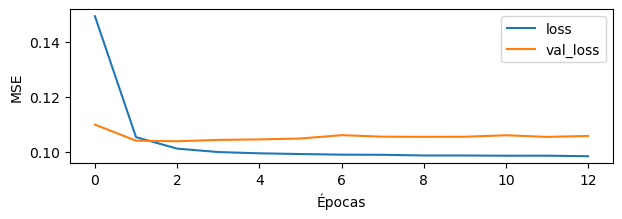

In [98]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [99]:
y_est = rede_neural.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    negative       0.86      0.85      0.86      5057
    positive       0.85      0.86      0.86      4943

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



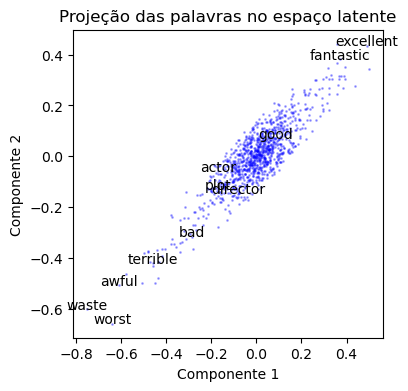

In [108]:
# Visualização 2: onde foi parar cada palavra?
v = rede_neural.get_layer('projecao').get_weights()[0]
plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='b')
for s in ["director", "actor", "bad", "good", "excellent", "plot", "worst", "terrible", "waste", "awful", "fantastic"]:
    _n = vectorizer.vocabulary_[s]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-20,20])
#plt.ylim([-20,20])
plt.show()